# Stage 1 : Feasibility Checks for Classification

We are going to utilize the Feature engineering insights and Unsupervised learning tasks that we did in other notebooks to classify a sentence into either 'Needs simplification' or 'Doesn't need simplification'. To achieve this process, we are going to follow this structure

1. First we will build an As-Is model plainly with the given text corpus (No corrections) and compare it with the Dummy classifiers
2. If the As-Is model is doing better than a Dummy classifier, then we will investigate the following -
  *   With stop words removal, investigate the model accuracy
  *   Without stop words removal, investigate the model accuracy
  *   Using NLTK's lemmatizer, investigate the model accuracy
3. If the model accuracy improves considerably, then we will start the advanced techniques

In [1]:
#Import necessary libraries only
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
import gensim.downloader
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
import pickle
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
from scipy.sparse import coo_matrix, hstack
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.ensemble import StackingClassifier
import nltk
from nltk import pos_tag,pos_tag_sents
nltk.download('averaged_perceptron_tagger')
from sklearn.preprocessing import StandardScaler
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
from time import time
import matplotlib.pyplot as plt
nltk.download('wordnet')
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
RANDOM_SEED = 7007

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# Connect the Notebook to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import the required datasets only
train_df_1=pd.read_csv('/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd/WikiLarge_Train.csv')
test_df_1=pd.read_csv('/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd/WikiLarge_Test.csv')

In [4]:
# As mentioned in the earlier notebooks, we found that there are few duplicates 
# in the Training dataset and test dataset. We will not alter the test dataset
# However, the training dataset needs to be deduped 
train_df_1.drop_duplicates('original_text',inplace = True)

In [5]:
# Let's now divide the training dataset into two groups - Training and Dev / 
# Validation dataset. We are going to extract 86.5% records of base training
# dataset for further exploration
df=train_df_1.sample(frac=1,random_state=RANDOM_SEED)
train_df,dev_df=np.split(df,[int(.865 * len(df))])

In [6]:
#Let's print the shapes of the dataframes that we created right now
train_df.shape,dev_df.shape

((300462, 2), (46894, 2))

## As-Is Model compared with Dummy classifier

In [7]:
# Lets first do a simple Count based Regression classifier

vectorizer = TfidfVectorizer(min_df = 500)
X_train = vectorizer.fit_transform(train_df.original_text) 
y_train = list(train_df.label)
X_dev = vectorizer.transform(dev_df.original_text)
y_dev = list(dev_df.label)

In [8]:
#Baseline Dummy Classifier and find the outcome accuracy
clf_dum_st1 = DummyClassifier(strategy="uniform",random_state=RANDOM_SEED).fit(X_train,y_train)
rand_dev_preds = clf_dum_st1.predict(X_dev)
rand_acc = accuracy_score(y_dev,rand_dev_preds)

In [9]:
# Start with Logistic Regression - We are just going to understand the predictive
# power of the algorithm and see the accuracy
clf = LogisticRegression(random_state=RANDOM_SEED,solver = 'lbfgs').fit(X_train[:10000],y_train[:10000])

In [10]:
#Now that the model is trained on the first 10000 entries, lets try predicting
#the outcome. Let's also calculate F1 Score and Accuracy
lr_tiny_dev_preds = clf.predict(X_dev)
lr_f1 = f1_score(y_dev, lr_tiny_dev_preds)
lr_acc = accuracy_score(y_dev,lr_tiny_dev_preds)

In [11]:
#Base for a set of first 10K articles, the accuracy is coming to be 63.5% - A lift of 14% from the Baseline accuracy of 50%
lr_acc,rand_acc

(0.6366059623832473, 0.5021964430417537)

In [12]:
#Let's store the model accuracies
model_acc = dict()
model_acc['Dummy_Classifier'] = rand_acc
model_acc['LR_10000_samples'] = lr_acc

Base for a set of first 10K articles, the accuracy is coming to be 63.5% - A lift of 14% from the Baseline accuracy of 50%. While this looks wonderful, there is still a lot of room for improvement. Let's see how these things change when we use the full dataset

In [13]:
#lr>rf>random
clf = LogisticRegression(random_state=RANDOM_SEED,solver = 'lbfgs',max_iter = 1000).fit(X_train,y_train)

In [14]:
lr_full_dev_preds = clf.predict(X_dev)
lr_acc = accuracy_score(y_dev,lr_full_dev_preds)
print(lr_acc)
#Lr is the clear winner here with 67% of Dev Accuracy
model_acc['LR_Full_sample'] = lr_acc

0.6687635944897001


With full dataset, the accuracy improves to 66.8% - Not bad. This also gives hope that the model accuracy can be further improved

## As-Is Model improvement

Now that we are able to establish the fact that classification is improving the base label rate of 1's (Needing Correction) we should now explore the following options 

  *   With stop words removal, investigate the model accuracy
  *   Using NLTK's lemmatizer, investigate the model accuracy

In [ ]:
# Lets first write one smart helper function
# Class object for lemmatizer

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# Lemmatize the stop words
tokenizer=LemmaTokenizer()

def base_classifier(stop=True, lemma_needed = False):
  if stop and not(lemma_needed):
    print("Scenario running for Stopwords removal and no Lemmatization")
    vectorizer = TfidfVectorizer(min_df = 500, stop_words={'english'})
  if stop and lemma_needed:
    print("Scenario running for Stopwords removal and Lemmatization")
    vectorizer = TfidfVectorizer(min_df = 500, tokenizer=tokenizer,stop_words={'english'})
  if not(stop) and lemma_needed:
    print("Scenario running for Lemmatization only")
    vectorizer = TfidfVectorizer(min_df = 500, tokenizer=tokenizer)
  X_train = vectorizer.fit_transform(train_df.original_text) 
  y_train = list(train_df.label)
  X_dev = vectorizer.transform(dev_df.original_text)
  y_dev = list(dev_df.label)
  clf = LogisticRegression(random_state=RANDOM_SEED,solver = 'lbfgs',max_iter = 1000)
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_dev)
  tf_bit_acc = accuracy_score(y_dev,y_pred)
  return tf_bit_acc

In [ ]:
# We are gettign an accuracy of 66.7% - 0.1% less than what we got with out stop
# words removed (previous best - 66.8%). This is interesting - The sentences in 
# general needs stop words to differentiate if there is a need for correction or not
model_acc['LR_No_Stopwords'] = base_classifier()
# We are gettign an accuracy of 67.6% - 1% more than what we got with out stop
# words removed. Way to go - Please note that here we removed the entire stop words
# lemmatized the words for meaningful inference. Can we do better if we dont remove
# stop words?
model_acc['LR_Stopwords_Lemma'] = base_classifier(lemma_needed = True)

Scenario running for Stopwords removal and no Lemmatization
Scenario running for Stopwords removal and Lemmatization


In [ ]:
# A similar performance is observed
model_acc['LR_NoStop_OnlyLemma'] = base_classifier(lemma_needed = True,stop=False)

Scenario running for Lemmatization only


The three scenarios that we say are giving us more hope that model accuracy can be further improved going forward

In [ ]:
model_acc['LR_NoStop_OnlyLemma'],model_acc['LR_Stopwords_Lemma']

(0.6791273936964217, 0.6790847443169702)

### As-Is Model additional tasks

Let's use LR_NoStop_OnlyLemma scenario further and see if min_df and ngrams have any impact on the classification

In [ ]:
# Only use Bi gram and tri gram along with unigram. The idea here is does the
# inclusion of Bi/Tri gram have any bearing on the sentence corrections?
# Let's tweak the min_df parameter for various values
def experiment_vectorizer(min_df,clf,gram_range = (1,3)):
  vectorizer = TfidfVectorizer(tokenizer=tokenizer,min_df = min_df,ngram_range=gram_range)
  X_train = vectorizer.fit_transform(train_df.original_text) 
  y_train = list(train_df.label)
  X_dev = vectorizer.transform(dev_df.original_text)
  y_dev = list(dev_df.label)
  X_test = vectorizer.transform(test_df_1.original_text)
  clf = clf.fit(X_train,y_train)
  tf_bit_lr_pred=clf.predict(X_dev)
  tf_bit_acc = accuracy_score(y_dev,tf_bit_lr_pred)
  print(tf_bit_acc)
  return tf_bit_acc

In [ ]:
model_vals = dict()
min_df_range = [100,150,200,250,300,500]

for i in min_df_range:
  model_vals[i] = experiment_vectorizer(i,LogisticRegression(random_state=RANDOM_SEED,solver = 'lbfgs',max_iter = 1000))

0.7067855162707383
0.7035441634324221
0.7017102401160064
0.7010491747345076
0.6974026527914019
0.6921994284983154


In [ ]:
model_acc['LR_Lemma_mindf100'] = model_vals[100]

Clearly unigram to trigram is improving the model accuracies. Combined with the min_df functionality of min_df = 100, there is super improvement in model accuracy from 67% to 70.4%

In [ ]:
# here is the final model and vectorizer that we have
vectorizer = TfidfVectorizer(tokenizer=tokenizer,min_df = 100,ngram_range=(1,3))
X_train = vectorizer.fit_transform(train_df.original_text) 
y_train = list(train_df.label)
X_dev = vectorizer.transform(dev_df.original_text)
y_dev = list(dev_df.label)
X_test = vectorizer.transform(test_df_1.original_text)
clf = LogisticRegression(random_state=RANDOM_SEED,solver = 'lbfgs',max_iter = 1000)
clf = clf.fit(X_train,y_train)
tf_bit_lr_pred=clf.predict(X_dev)
tf_bit_acc = accuracy_score(y_dev,tf_bit_lr_pred)

In [ ]:
model_acc.keys()

dict_keys(['Dummy_Classifier', 'LR_10000_samples', 'LR_Full_sample', 'LR_No_Stopwords', 'LR_Stopwords_Lemma', 'LR_NoStop_OnlyLemma', 'LR_Lemma_mindf100'])

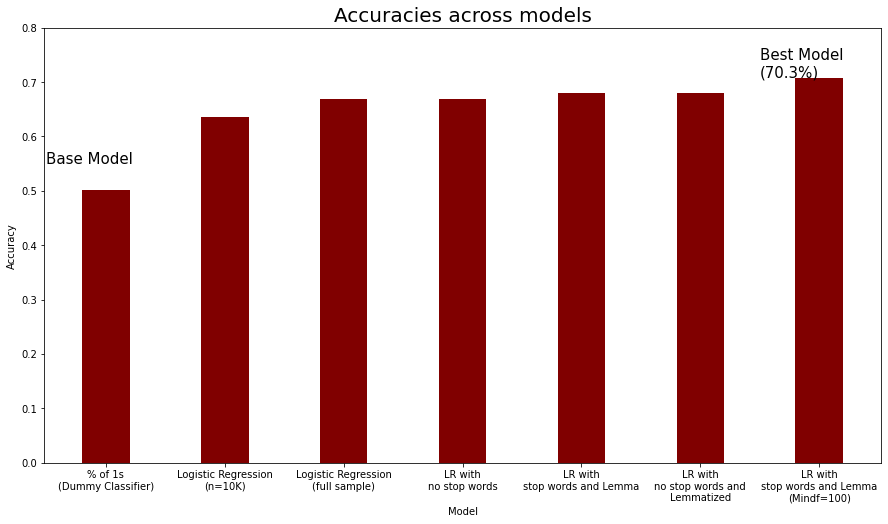

In [ ]:
# Summing up everything

fig = plt.figure(figsize=(15, 8))

a = fig.add_subplot(1,1,1)
a.bar(['% of 1s\n(Dummy Classifier)','Logistic Regression\n(n=10K)','Logistic Regression\n(full sample)','LR with\nno stop words','LR with\nstop words and Lemma','LR with\nno stop words and\nLemmatized','LR with\nstop words and Lemma\n(Mindf=100)'], model_acc.values(), color ='maroon',width = 0.4)
a.annotate("Best Model\n(70.3%)",(5.5,0.71),fontsize=15)
a.annotate("Base Model",(-0.5,0.55),fontsize=15)
a.set(ylabel='Accuracy',xlabel ='Model',ylim = (0,0.8))
a.set_title("Accuracies across models", fontdict={'fontsize': '20', 'fontweight' : '20'})
fig.show()

In [ ]:
path_to_save = '/content/drive/Shareddrives/MADS_Milestone2_Drive/Images/Baseline_models.png'
fig.savefig(path_to_save,dpi = 100)

In [15]:
# Before moving further, lets first save the Current model and also the vectorize for future reference and usage

pickle_out = open("/content/drive/Shareddrives/MADS_Milestone2_Drive/App/vectorizer.pickle","wb")
pickle.dump(vectorizer, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/Shareddrives/MADS_Milestone2_Drive/App/lr_trained.pickle","wb")
pickle.dump(clf, pickle_out)
pickle_out.close()

# Stage 2 : Building from Feature engineering and Unsupervised learning

Across this project, we are able to create word vectors from Gensim package along with TFIDF+word Parts of speech tag (with out any min_df conditions). The plan here is if we use these two datasets, will we able to improve the model accuracy? The strategy here is -

  *   A pickle file with all these datasets is created earlier. We will import the pickle file and namely use the word vector and tfidf blocks that are present in the pickle file
  *   We will further build a pipeline of models (Logistic Regression, SVC, Ridge classifier, Naive Bayes Bernoulli classifier). We tried Random forest. However owing to the size of the dataset, the results are not giving us desirable results

The aim of this block is to further improve the model accuracy from 70.3%

In [ ]:
# Import the pickle file as 1st step
objects = []
with (open("/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/pkl_dict.pickle", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [ ]:
#Let's write simple function to extract the details needed
def train_dev_builder(keys):
  X_train = objects[0][keys[0]]
  X_dev = objects[0][keys[1]]
  X_test = objects[0][keys[2]]
  return X_train,X_dev,X_test

y_train=objects[0]['y_train']
y_dev=objects[0]['y_dev']
y_test=objects[0]['y_test']

In [ ]:
def benchmark(X_train,y_train,X_dev,y_dev,clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    t0 = time()
    pred = clf.predict(X_dev)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    score = metrics.accuracy_score(y_dev, pred)
    print("accuracy:   %0.3f" % score)
    print("classification report:")
    print(metrics.classification_report(y_dev, pred))
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_dev, pred))
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [ ]:
#Helper function 2

def pipeline_all_models(X_train,y_train,X_dev,y_dev,key):  
  results = []
  for clf, name in ((RidgeClassifier(tol=1e-2, solver="auto",random_state = RANDOM_SEED), "Ridge Classifier"),
                    (Perceptron(max_iter=50,random_state = RANDOM_SEED), "Perceptron"),
                    (PassiveAggressiveClassifier(max_iter=1000,random_state = RANDOM_SEED),"Passive-Aggressive"),
                    (LogisticRegression(random_state = RANDOM_SEED,solver = 'lbfgs',max_iter = 1000),"LR"),
                    (BernoulliNB(),"NB")):
      print('=' * 80)
      print(name)
      results.append(benchmark(X_train,y_train,X_dev,y_dev,clf))

  for penalty in ["l1"]:
      print('=' * 80)
      print("%s penalty" % penalty.upper())
      # Train Liblinear model
      results.append(benchmark(X_train,y_train,X_dev,y_dev,LinearSVC(penalty=penalty, dual=False,max_iter=1000,tol=1e-3,random_state = RANDOM_SEED)))
      # Train SGD model
      results.append(benchmark(X_train,y_train,X_dev,y_dev,SGDClassifier(alpha=.0001, max_iter=1000,penalty=penalty,random_state = RANDOM_SEED)))
  result_best = pd.DataFrame(results)
  result_best.columns = ['Model','Accuracy','Train Time','Score Time']
  result_best['Key'] = key
  return result_best[result_best['Accuracy']==np.max(result_best['Accuracy'])]

### Best model till date

In [ ]:
# here is the final model and vectorizer that we have
vectorizer = TfidfVectorizer(tokenizer=tokenizer,min_df = 100,ngram_range=(1,3))
X_train = vectorizer.fit_transform(train_df.original_text) 
X_dev = vectorizer.transform(dev_df.original_text)
X_test = vectorizer.transform(test_df_1.original_text)

In [ ]:
y_train = list(train_df.label)
y_dev = list(dev_df.label)

In [ ]:
result_best = pipeline_all_models(X_train,y_train,X_dev,y_dev,key = 'LR with\nstop words and Lemma\n(Mindf=100)')

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=7007,
                solver='auto', tol=0.01)
train time: 2.121s
test time:  0.005s
accuracy:   0.702
classification report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70     23487
           1       0.70      0.71      0.70     23407

    accuracy                           0.70     46894
   macro avg       0.70      0.70      0.70     46894
weighted avg       0.70      0.70      0.70     46894

confusion matrix:
[[16381  7106]
 [ 6878 16529]]
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs

## Word PoS Tags only

In [ ]:
X_train_wpos,X_dev_wpos,X_test_wpos = train_dev_builder(['word_pos_tag_count_X_train','word_pos_tag_count_X_dev','word_pos_tag_count_X_test'])
y_train=objects[0]['y_train']
y_dev=objects[0]['y_dev']
y_test=objects[0]['y_test']

In [ ]:
result_postags = pipeline_all_models(X_train_wpos,y_train,X_dev_wpos,y_dev,key = 'Word PoS Tags')

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=7007,
                solver='auto', tol=0.01)
train time: 0.547s
test time:  0.008s
accuracy:   0.648
classification report:
              precision    recall  f1-score   support

           0       0.63      0.71      0.67     23487
           1       0.67      0.58      0.62     23407

    accuracy                           0.65     46894
   macro avg       0.65      0.65      0.65     46894
weighted avg       0.65      0.65      0.65     46894

confusion matrix:
[[16693  6794]
 [ 9728 13679]]
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 24.710s
test time:  0.004s
accuracy:   0.648
classification report:
              precision    recall  f1-score   support

           0       0.63      0.71      0.67     23487
           1       0.67      0.59      0.62     23407

    accuracy                           0.65     46894
   macro avg       0.65      0.65      0.65     46894
weighted avg       0.65      0.65      0.65     46894

confusion matrix:
[[16657  6830]
 [ 9685 13722]]
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=7007, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 62.382s
test tim

## Combined Word vector tagging

In [ ]:
X_train_w2v,X_dev_w2v,X_test_w2v = train_dev_builder(['combined_word_vector_X_train','combined_word_vector_X_dev','combined_word_vector_X_test'])
y_train=objects[0]['y_train']
y_dev=objects[0]['y_dev']
y_test=objects[0]['y_test']

In [ ]:
results_w2v = pipeline_all_models(X_train_w2v,y_train,X_dev_w2v,y_dev,key = 'Word to Vec Tags')

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=7007,
                solver='auto', tol=0.01)
train time: 0.816s
test time:  0.023s
accuracy:   0.622
classification report:
              precision    recall  f1-score   support

           0       0.61      0.68      0.64     23487
           1       0.64      0.56      0.60     23407

    accuracy                           0.62     46894
   macro avg       0.62      0.62      0.62     46894
weighted avg       0.62      0.62      0.62     46894

confusion matrix:
[[15940  7547]
 [10190 13217]]
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train time: 171.711s
test time:  0.012s
accuracy:   0.683
classification report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70     23487
           1       0.70      0.63      0.67     23407

    accuracy                           0.68     46894
   macro avg       0.69      0.68      0.68     46894
weighted avg       0.69      0.68      0.68     46894

confusion matrix:
[[17243  6244]
 [ 8607 14800]]
NB
________________________________________________________________________________
Training: 
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.243s
test time:  0.040s
accuracy:   0.650
classification report:
              precision    recall  f1-score   support

           0       0.64      0.69      0.66     23487
           1       0.66      0.61      0.63     23407

    accuracy                           0.65     46894
   macro avg       0.65      0.65      0.65     46894
weighted avg       0.65   

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 113.068s
test time:  0.006s
accuracy:   0.632
classification report:
              precision    recall  f1-score   support

           0       0.62      0.67      0.65     23487
           1       0.64      0.60      0.62     23407

    accuracy                           0.63     46894
   macro avg       0.63      0.63      0.63     46894
weighted avg       0.63      0.63      0.63     46894

confusion matrix:
[[15686  7801]
 [ 9459 13948]]
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=7007, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 100.980s
test t

In [ ]:
results_w2v

,Model,Accuracy,Train Time,Score Time,Key
3,LogisticRegression,0.683307,171.710635,0.011861,Word to Vec Tags


## TFIDF Vector

In [ ]:
X_train_tfidf,X_dev_tfidf,X_test_tfidf = train_dev_builder(['tfidf_vector_X_train','tfidf_vector_X_dev','tfidf_vector_X_test'])
y_train=objects[0]['y_train']
y_dev=objects[0]['y_dev']
y_test=objects[0]['y_test']

In [ ]:
results_tfidf = pipeline_all_models(X_train_tfidf,y_train,X_dev_tfidf,y_dev,key = 'TFiDF Tags')

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=7007,
                solver='auto', tol=0.01)
train time: 2.817s
test time:  0.005s
accuracy:   0.627
classification report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     23487
           1       0.63      0.62      0.62     23407

    accuracy                           0.63     46894
   macro avg       0.63      0.63      0.63     46894
weighted avg       0.63      0.63      0.63     46894

confusion matrix:
[[14858  8629]
 [ 8854 14553]]
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs

## Summary

We went through various iterations of the features and were able to get the accuracies across. In this section, we will select top model within each feature space and compare how they are stacking. They key here is to understand what is working and what is not working on a whole

In [ ]:
#Concatenate the best model results
Final_summary = pd.concat([result_best,results_w2v,results_tfidf,result_postags])

In [ ]:
Final_summary

,Model,Accuracy,Train Time,Score Time,Key
3,LogisticRegression,0.706786,31.101215,0.005004,LR with\nstop words and Lemma\n(Mindf=100)
3,LogisticRegression,0.683307,171.710635,0.011861,Word to Vec Tags
3,LogisticRegression,0.648505,11.189157,0.004442,TFiDF Tags
5,LinearSVC,0.647823,24.710474,0.004134,Word PoS Tags


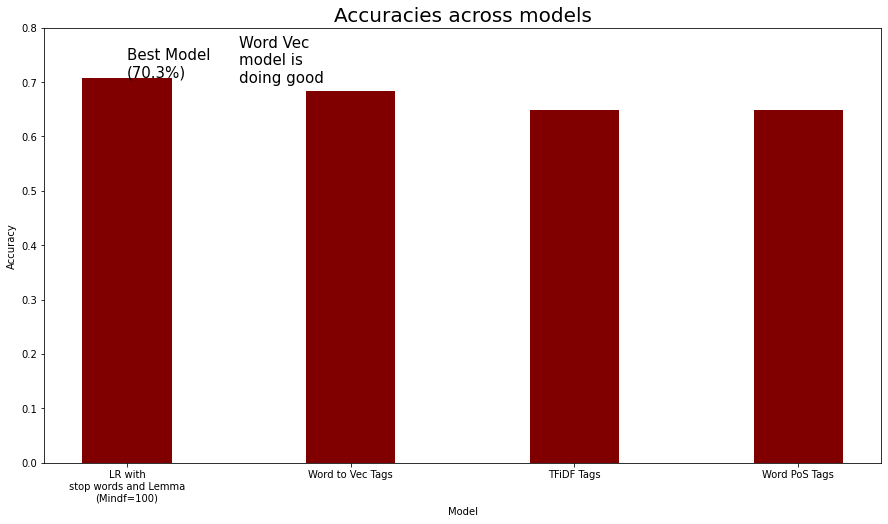

In [ ]:
#PLot the trend

fig = plt.figure(figsize=(15, 8))

a = fig.add_subplot(1,1,1)
a.bar(Final_summary.Key, Final_summary.Accuracy, color ='maroon',width = 0.4)
a.annotate("Best Model\n(70.3%)",(0,0.71),fontsize=15)
a.annotate("Word Vec\nmodel is\ndoing good",(0.5,0.7),fontsize=15)
a.set(ylabel='Accuracy',xlabel ='Model',ylim = (0,0.8))
a.set_title("Accuracies across models", fontdict={'fontsize': '20', 'fontweight' : '20'})
fig.show()

**Learnings**

The best model till date with out any feature engineering is doing exceptionally great. The TFIDF tags and Word PoS Tags are not really improving the accuracy a lot. However, Word to Vector representation is giving considerable reasonable accuracy of 68%. The earlier feature engineering was done with Words that appear in documents at least 5 times - This must be causing the noise in the system and reducing the predictive power of the Word2Vec

## Failure Analysis on Best Fit model

In [ ]:
# here is the final model and vectorizer that we have
vectorizer = TfidfVectorizer(tokenizer=tokenizer,min_df = 100,ngram_range=(1,3))
X_train = vectorizer.fit_transform(train_df.original_text) 
y_train = list(train_df.label)
X_dev = vectorizer.transform(dev_df.original_text)
y_dev = list(dev_df.label)
X_test = vectorizer.transform(test_df_1.original_text)
clf = LogisticRegression(random_state=RANDOM_SEED,solver = 'lbfgs',max_iter = 1000)
clf = clf.fit(X_train,y_train)
tf_bit_lr_pred=clf.predict(X_dev)
tf_bit_acc = accuracy_score(y_dev,tf_bit_lr_pred)

In [ ]:
def tag_counter(pos_tags):
  count_tg={}
  for word,tag in pos_tags:
    if tag in count_tg:
      count_tg[tag]+=1
    else:
      count_tg[tag]=1
  return count_tg

In [ ]:
# Let's create a copy of the validation / dev dataset

def failure_analysis(list_preds,a,b):
  df = dev_df.copy()
  df['y_pred'] = list_preds
  df['flg'] = np.where((df['label']==0)&(df['y_pred']==0),'Correct Zeros',
                       np.where((df['label']==1)&(df['y_pred']==1),'Correct Ones',
                                np.where((df['label']==1)&(df['y_pred']==0),'Wrong Zeroes','Wrong Ones')))
  # Extracting character counts
  df['smpl_char_count']=df['original_text'].str.len()
  # Extracting token counts
  df['smpl_tkn_count']=df['original_text'].str.split(' ').str.len()
  # Extracting chars per token
  df['avg_chars_per_tkn']=df['smpl_char_count']/df['smpl_tkn_count']
  # Extracting char count of largest token
  df['chars_lrgst_tkn']=df['original_text'].apply(lambda x: len(max(x.split(' '), key=len)))
  # Extracting POS Tag counts per text this takes ~10mins to run !
  tags=df['original_text'].str.split().map(pos_tag)
  tags2=tags.map(tag_counter)
  tags3=tags2.apply(pd.Series)
  tags3.fillna(0,inplace=True)  # filling the NaN values with 0s to enable computation

  df_fin = pd.merge(df,tags3,left_index = True,right_index = True,how = 'inner')
  #Box plots
  sns.boxplot(x='smpl_char_count', y="flg",data = df,ax = a)
  sns.boxplot(x='smpl_tkn_count', y="flg",data = df,ax = b)
  a.set(ylabel="Flag",xlabel = "value",title = "# of Characters")   
  b.set(ylabel="Flag",xlabel = "value",title = "# of Tokens") 

  df_fin[tags3.columns] = df_fin[tags3.columns].apply(lambda x:x/df_fin['smpl_tkn_count'])

  #return df.groupby(['flg','label','y_pred']).agg({'smpl_char_count':'mean','smpl_tkn_count':'mean','original_text':'count'}),df_fin.groupby('flg').mean()[tags3.columns]
  #return df_fin.groupby('flg').mean()[tags3.columns]
  return df_fin

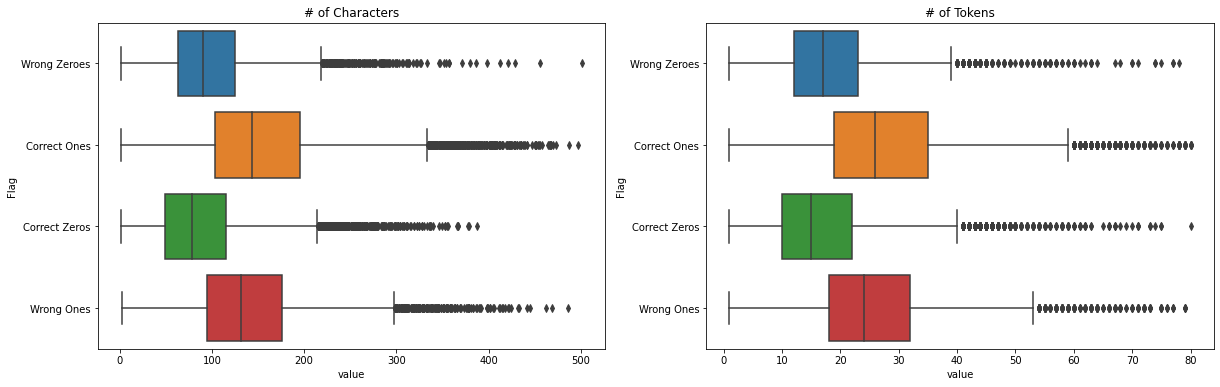

In [ ]:
fig =  plt.figure(figsize=(20,6))
a1 = fig.add_subplot(121)
a2 = fig.add_subplot(122)
agg1 = failure_analysis(tf_bit_lr_pred,a1,a2)

In [ ]:
path_to_save = '/content/drive/Shareddrives/MADS_Milestone2_Drive/Images/Failure_Analysis.png'
fig.savefig(path_to_save,dpi = 100)

In [ ]:
agg1.columns

Index(['original_text', 'label', 'y_pred', 'flg', 'smpl_char_count',
       'smpl_tkn_count', 'avg_chars_per_tkn', 'chars_lrgst_tkn', 'NNP', 'NNS',
       'VBZ', 'RB', 'IN', ',', 'CC', 'DT', 'JJ', 'NN', '.', 'VBP', 'CD', 'POS',
       'VBN', 'TO', 'VB', 'VBG', ':', 'EX', 'VBD', '''', 'JJR', 'WP', 'PRP',
       'RBS', 'PRP$', 'NNPS', 'RP', 'RBR', 'WRB', 'WDT', 'JJS', 'MD', '$',
       'FW', '#', '``', 'PDT', 'SYM', 'WP$', 'UH', 'LS'],
      dtype='object')

In [ ]:
(np.mean(agg1[['NNP', 'NNS','VBZ', 'RB', 'IN', 'CC', 'DT', 'JJ', 'NN', 'VBP', 'CD', 'POS','VBN', 'TO', 'VB', 'VBG', 'EX', 
                           'VBD','JJR', 'WP', 'PRP','RBS', 'PRP$', 'NNPS', 'RP', 'RBR', 'WRB', 'WDT', 'JJS', 'MD','FW', 'PDT', 'SYM', 'WP$', 'UH', 'LS']])).sort_values(ascending = False)

NNP     0.187796
NN      0.139198
IN      0.107725
DT      0.092178
JJ      0.060275
NNS     0.042007
CD      0.037306
VBZ     0.030696
VBD     0.029576
CC      0.025337
VBN     0.023981
RB      0.020454
PRP     0.015044
TO      0.012383
VB      0.010703
VBP     0.009669
VBG     0.009394
PRP$    0.006917
POS     0.004026
WDT     0.003569
MD      0.003210
NNPS    0.002708
JJS     0.002318
WRB     0.001815
WP      0.001545
JJR     0.001516
EX      0.001001
RP      0.000923
RBS     0.000720
FW      0.000635
RBR     0.000578
PDT     0.000179
SYM     0.000094
WP$     0.000090
UH      0.000020
LS      0.000001
dtype: float64

In [ ]:
Raw_data = agg1.groupby('flg').mean()[['NNP','NN','IN','DT','JJ','NNS','CD']]

In [ ]:
Raw_data = Raw_data.T.reset_index()

In [ ]:
Raw_data

flg,index,Correct Ones,Correct Zeros,Wrong Ones,Wrong Zeroes
0,NNP,0.183356,0.196322,0.174007,0.192267
1,NN,0.137311,0.146462,0.130722,0.134924
2,IN,0.119111,0.095935,0.115007,0.100827
3,DT,0.096707,0.088821,0.093559,0.087748
4,JJ,0.064442,0.055483,0.060991,0.060940
5,NNS,0.037779,0.044394,0.044935,0.043577
6,CD,0.035045,0.039762,0.036495,0.037736


[Text(0, 0.5, '% of tokens'),
 Text(0.5, 0, 'PoS'),
 Text(0.5, 1.0, '% of PoS in sentences')]

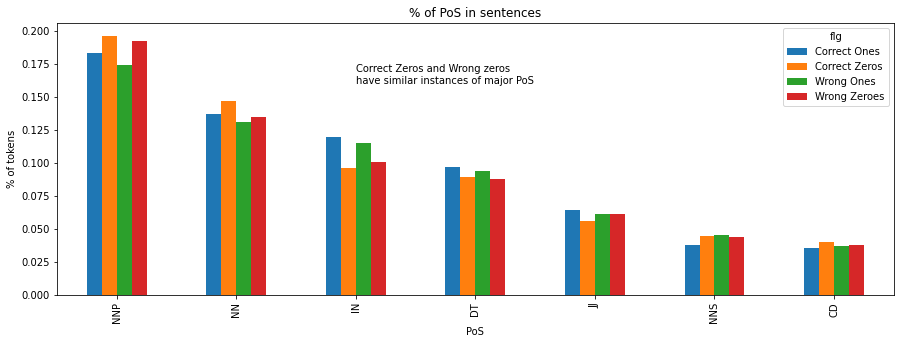

In [ ]:
#Grouped Column chart
fig =  plt.figure(figsize=(15,5))
a1 = fig.add_subplot(111)
# plot grouped bar chart
Raw_data.plot(x='index',
        kind='bar',
        stacked=False,
        title='Grouped Bar Graph with dataframe',ax = a1)
a1.annotate('Correct Zeros and Wrong zeros\nhave similar instances of major PoS',xy = (2,0.16))
a1.set(xlabel='PoS',ylabel = '% of tokens',title = '% of PoS in sentences')

In [ ]:
path_to_save = '/content/drive/Shareddrives/MADS_Milestone2_Drive/Images/Failure_Analysis_v1.png'
fig.savefig(path_to_save,dpi = 100)

**Key learnings**

1. Correct predicted labels that needed correction in general have higher tokens and higher charaters. While the converse is true for the senetences that needed correction. A similar trend is observed even in PoS tagging
2. While this is true, there are certain exemptions ('Wrong Ones' and 'Wrong Zeroes') For instance, 'Wrong Ones' are long sentences and the algorithm is probably learning the # of tokens to be higher (slightly more dense vector for the document) and inturn flagging them to be 'Correction needed'

These two instances basically emphasize the fact that along with token lengths, there is also a need to understand the structure of the sentences to be flagged as 'Correction needed' or 'Correction Not needed'

# Stage - 3: Revisit Feature engineering

While the other feature representations are not giving us good result, we think there is a merit in using word2vec representations going forward. As per the feedback received from our peer groups, we are going to try following feature engineering steps :

* PoS tagging and Token length tagging to the base dataset
* Word2Vec representation



In [ ]:
# Let's create a copy of the validation / dev dataset

def pos_token_tagger(df1):
  df = df1.copy()
  # Extracting character counts
  df['smpl_char_count']=df['original_text'].str.len()
  # Extracting token counts
  df['smpl_tkn_count']=df['original_text'].str.split(' ').str.len()
  # Extracting chars per token
  df['avg_chars_per_tkn']=df['smpl_char_count']/df['smpl_tkn_count']
  # Extracting char count of largest token
  df['chars_lrgst_tkn']=df['original_text'].apply(lambda x: len(max(x.split(' '), key=len)))
  # Extracting POS Tag counts per text this takes ~10mins to run !
  tags=df['original_text'].str.split().map(pos_tag)
  tags2=tags.map(tag_counter)
  tags3=tags2.apply(pd.Series)
  tags3.fillna(0,inplace=True)  # filling the NaN values with 0s to enable computation

  df_fin = pd.merge(df,tags3,left_index = True,right_index = True,how = 'inner')
  df_fin[tags3.columns] = df_fin[tags3.columns].apply(lambda x:x/df_fin['smpl_tkn_count'])
  return df_fin

In [ ]:
train_1 = pos_token_tagger(train_df)
dev_1 = pos_token_tagger(dev_df)

In [ ]:
test_1 = pos_token_tagger(test_df_1)

In [ ]:
from gensim.models.word2vec import Word2Vec
import re

In [ ]:
re_tokenized_text=[]
for t in train_1.original_text:
    t=t.lower()
    tokens=re.findall(r'\w+',t)
    re_tokenized_text.append(tokens)

# Search for word2vec model pickle object, only if it does not exist should you run the model 
# if os.path.exists("/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/word2vec_model_dict.pickle"):
#   print('\n Word2Vec Pickle Object already exists at :/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/word2vec_model_dict.pickle')

# else:
word2vec_model = Word2Vec(sentences=re_tokenized_text, 
                          size=100,
                          window=3,
                          min_count=100,
                          workers=4,
                          seed=RANDOM_SEED)

# word2vec_model.save("word2vec_model.model")

word2vec_model_dict={'word2vec_model_dict':word2vec_model}


In [ ]:
type(word2vec_model_dict['word2vec_model_dict']),type(glove_vectors)

(gensim.models.word2vec.Word2Vec,
 gensim.models.keyedvectors.Word2VecKeyedVectors)

In [ ]:
glove_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def generate_dense_features(tokenized_texts, word_vectors): 
    train_list=[]
    for toknzd_doc in tokenized_texts:
        # skipping words in tokens which are not in vocab of word vector
        words = [w for w in toknzd_doc if w in word_vectors.wv.vocab]
        
        if len(words)>0:
            word_mean=np.mean(word_vectors[words],axis=0)
        else:
            word_mean=np.zeros(word_vectors.vector_size)
            
        train_list.append(word_mean)
        
    return np.array(train_list)

def prelim(df):
  tokenized_train_items=[]
  for t in df.original_text:
    t=t.lower()
    tokens=re.findall(r'\w+',t)
    tokenized_train_items.append(tokens)
  vecs = generate_dense_features(tokenized_train_items, glove_vectors)
  return vecs


X_train_w2v = prelim(train_df)
X_dev_w2v = prelim(dev_df)
X_test_w2v = prelim(test_df_1)

# Checking shape of X_train_w2v
print(X_train_w2v.shape)
print(X_dev_w2v.shape)
print(X_test_w2v.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


(300462, 300)
(46894, 300)
(119092, 300)


In [ ]:
clf = LogisticRegression(random_state=RANDOM_SEED,solver = 'lbfgs',max_iter = 1000)
clf = clf.fit(X_train_w2v,y_train)
tf_bit_lr_pred=clf.predict(X_dev_w2v)
tf_bit_acc = accuracy_score(y_dev,tf_bit_lr_pred)

In [ ]:
tf_bit_acc

0.6320211540922079

# Summary

Word2Vec from pre-trained corpus: We utilized the Gensim pre-trained word2vec vectors. For every token in the document, we extracted the vector notation and averaged out the vectors to represent each document. The method resulted in a model accuracy of only 64%. Owing to this, we went ahead with the Lemmatized text LR with stop words and Lemma (mindf = 100) model for further failure analysis

While these are good findings, the improvements that needs to be done can be a) treat the sentence as sequence b) check for coreferences in the document and feed into the classifier to ensure that the sequence is captured

In [ ]:
#!pip install watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.1
    Uninstalling importlib-metadata-4.8.1:
      Successfully uninstalled importlib-metadata-4.8.1


In [ ]:
%reload_ext watermark
%watermark
%watermark --iversions

Last updated: 2021-09-26T09:27:14.510811+00:00

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

nltk      : 3.2.5
google    : 2.0.3
matplotlib: 3.2.2
numpy     : 1.19.5
IPython   : 5.5.0
pandas    : 1.1.5
scipy     : 1.4.1
gensim    : 3.6.0
sklearn   : 0.0
seaborn   : 0.11.2

